In [1]:
# import tensorflow as tf
import numpy as np
import os
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import io
from PIL import Image, ImageDraw
from io import BytesIO
import cv2
import math
%matplotlib inline

In [2]:
limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 11, 0, 13, 14, 15]

In [3]:
def skeleton_image(joints_2d, img):
    img_copy = img.copy()
#     colors = [(0,0,255), (0,255,0), (255,0,0), (255,0,255), (0,255,255), (255,255,0), (127,127,0), (0,127,0), (100,0,100), 
#           (255,0,255), (0,255,0), (0,0,255), (255,255,0), (127,127,0), (100,0,100), (50, 255, 100), (50, 50, 0)]
    
    colors = [(0,0,255), (0,255,0), (255,0,0), (255,0,255), (0,255,255), (255,255,0), (127,127,0), (0,127,0), (100,0,100), 
          (255,0,255), (0,255,0), (0,0,255), (255,255,0), (127,127,0), (100,0,100), (175,100,195), (255,125,25)]
    joints_2d = joints_2d
    for i in range(joints_2d.shape[0]):
        #         ax.text(joints_2d[i, 0], -joints_2d[i, 1], str(i))
        x_pair = [joints_2d[i, 0], joints_2d[limb_parents[i], 0]]
        y_pair = [joints_2d[i, 1], joints_2d[limb_parents[i], 1]]
        img_copy = cv2.line(img_copy, (int(x_pair[0]),int(y_pair[0])), (int(x_pair[1]),int(y_pair[1])), colors[i],4)

    return img_copy[:,:,::-1]

In [4]:
def get_gaussian_maps(mu, shape_hw, inv_std, mode='ankush'):
    """
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.

    STD: is the fixed standard dev.
    """
#   with tf.name_scope(None, 'gauss_map', [mu]):
    mu_y, mu_x = mu[:, :, 0:1], mu[:, :, 1:2]

#     y = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[0]))

#     x = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[1]))
    y = np.linspace(-1.0, 1.0, shape_hw[0])

    x = np.linspace(-1.0, 1.0, shape_hw[1])

    if mode in ['rot', 'flat']:
        mu_y, mu_x = np.expand_dims(mu_y, -1), np.expand_dims(mu_x, -1)

        y = np.reshape(y, [1, 1, shape_hw[0], 1])
        x = np.reshape(x, [1, 1, 1, shape_hw[1]])

        g_y = np.square(y - mu_y)
        g_x = np.square(x - mu_x)
        dist = (g_y + g_x) * inv_std**2
        dist1 = (g_y + g_x) * (inv_std*4)**2

        if mode == 'rot':
            g_yx = np.exp(-dist)
            g_yx1 = np.exp(-dist1)
        else:
            g_yx = np.exp(-np.pow(dist + 1e-5, 0.25))

    elif mode == 'ankush':
        y = np.reshape(y, [1, 1, shape_hw[0]])
        x = np.reshape(x, [1, 1, shape_hw[1]])

        g_y = np.exp(-np.sqrt(1e-4 + np.abs((mu_y - y) * inv_std)))
        g_x = np.exp(-np.sqrt(1e-4 + np.abs((mu_x - x) * inv_std)))

        g_y = np.expand_dims(g_y, axis=3)
        g_x = np.expand_dims(g_x, axis=2)
        g_yx = np.matmul(g_y, g_x)  # [B, NMAPS, H, W]

    else:
        raise ValueError('Unknown mode: ' + str(mode))

    g_yx = np.transpose(g_yx, axes=[0, 2, 3, 1])
    g_yx1 = np.transpose(g_yx1, axes=[0, 2, 3, 1])
    return g_yx, g_yx1

In [5]:
def get_rot_gaussian_maps(mu, shape_hw, inv_std1, inv_std2, angles, mode='ankush'):
    """
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.

    STD: is the fixed standard dev.
    """
#   with tf.name_scope(None, 'gauss_map', [mu]):
    mu_y, mu_x = mu[:, 0:1], mu[:, 1:2]     # (17, 1)

    
    y = []
    x = []
    for i in range(shape_hw[0]):
        y.append(np.linspace(-1.0, 1.0, shape_hw[0]))
        x.append(np.linspace(-1.0, 1.0, shape_hw[1]))
    y = np.stack(y, 0)
    x = np.stack(x, 0).T
    y = np.expand_dims(y, 0)
    x = np.expand_dims(x, 0)
    for i in range(mu.shape[0]-1):
        y = np.concatenate([y, y[0:1]],0)
        x = np.concatenate([x, x[0:1]],0)
    
    mu_y, mu_x = np.expand_dims(mu_y, -1), np.expand_dims(mu_x, -1)
    
    y = y - mu_y
    x = x - mu_x
    print (y.shape)
    print (x.shape)
    
    if mode in ['rot', 'flat']:
    
        # apply rotation to the grid
        yx_stacked = np.stack([y.reshape((mu.shape[0],-1)), x.reshape((mu.shape[0],-1))], 1)   # (17, 2, 196)
        rot_mat = np.stack([ np.stack([np.cos(angles), np.sin(angles)],1), 
                             np.stack([-np.sin(angles), np.cos(angles)],1) ], 2)   # (17, 2, 2)

        rotated = np.matmul(rot_mat, yx_stacked)   # (17, 2, 196)
        
        y_rot = rotated[:,0,:]   # (17, 196)
        x_rot = rotated[:,1,:]   # (17, 196)
                
        y_rot = np.reshape(y_rot, (mu.shape[0],shape_hw[0],shape_hw[0]))   # (17, 14, 14)
        x_rot = np.reshape(x_rot, (mu.shape[0],shape_hw[1],shape_hw[1]))   # (17, 14, 14)

        g_y = np.square(y_rot)   # (17, 14, 14)
        g_x = np.square(x_rot)   # (17, 14, 14)

        inv_std1 = np.expand_dims(np.expand_dims(inv_std1, 1), 1)
        inv_std2 = np.expand_dims(np.expand_dims(inv_std2, 1), 1)
        dist = (g_y * inv_std1**2 + g_x * inv_std2**2)

        if mode == 'rot':
            g_yx = np.exp(-dist)

        else:
            g_yx = np.exp(-np.pow(dist + 1e-5, 0.25))

    else:
        raise ValueError('Unknown mode: ' + str(mode))

    print (g_yx.shape)
#     g_yx = np.transpose(g_yx, axes=[1, 2, 0])
    g_yx = np.transpose(g_yx, axes=[2, 1, 0])

    return g_yx

In [6]:
def get_cropped_poses(img_orig_shape, mat_2d, img_size):

    m_2d = mat_2d.copy()
    
    x_min = int(np.min(mat_2d[:, 0])) - 10
    x_max = int(np.max(mat_2d[:, 0])) + 10
    y_min = int(np.min(mat_2d[:, 1])) - 10
    y_max = int(np.max(mat_2d[:, 1])) + 10
    
    y_dist = y_max-y_min
    
    x_dist = x_max-x_min
    
    if y_dist > x_dist:
        dist = (y_dist - x_dist)/2.0
        dist = int(dist)
        if (x_min-dist) < 0:
            x_min_full = 0
            x_max_full = y_dist
        elif (x_max + dist)>(img_orig_shape[1]-1):
                x_max_full = (img_orig_shape[1]-1)
                x_min_full = x_max_full - y_dist
        else:
            x_min_full = x_min - dist
            x_max_full = min(img_orig_shape[1]-1, x_min_full + y_dist)
        ratio = float(img_size)/(x_max_full - x_min_full)
        m_2d[:, 1] -= y_min
        m_2d[:, 0] -= x_min_full
    else:
        dist = (x_dist - y_dist)/2.0
        dist = int(dist)
        if (y_min-dist) < 0:
            y_min_full = 0
            y_max_full = x_dist
        elif (y_max + dist)>(img_orig_shape[0]-1):
                y_max_full = (img_orig_shape[0]-1)
                y_min_full = y_max_full - x_dist
        else:
            y_min_full = y_min - dist
            y_max_full = min(img_orig_shape[0]-1, y_min_full + x_dist)
        
        img_center_crop_params = [y_min_full, y_max_full, x_min, x_max]
        ratio = float(img_size)/(y_max_full - y_min_full)
        m_2d[:, 1] -= y_min_full
        m_2d[:, 0] -= x_min
        
    m_2d *= ratio
    return m_2d

In [40]:
image = [0]*22

In [42]:
image

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [41]:
len(image)

22

In [43]:
# MADS
# HipHop_HipHop1_C0 1535
image[1] = '/data/vcl/sid/mads_parsed/parsed_data/center_crops/HipHop_HipHop1_C0_video_1530_1620_34/crop_params_122_348_90_316_4.png'
# HipHop_HipHop3_C1 1085
image[2] = '/data/vcl/sid/mads_parsed/parsed_data/center_crops/HipHop_HipHop3_C1_video_1035_1125_23/crop_params_120_338_182_400_59.png'
# Jazz_Jazz3_C0/1130
image[3] = '/data/vcl/sid/mads_parsed/parsed_data/center_crops/Jazz_Jazz3_C0_video_1125_1215_25/crop_params_122_355_74_307_4.png'
# Jazz_Jazz6_C0/94
image[4] = '/data/vcl/sid/mads_parsed/parsed_data/center_crops/Jazz_Jazz6_C0_video_90_180_2/crop_params_103_373_103_373_3.png'
# Sports_Tennis_C0 1266
image[5] = '/data/vcl/sid/mads_parsed/parsed_data/center_crops/Sports_Tennis_C0_video_1260_1350_28/crop_params_133_349_173_389_5.png'

In [44]:
# H36
# S1_Directions_60457274 421
image[6] = '/data/vcl/sid/human36_parsed/parsed_data/center_crops/S1_Directions_60457274_video_405_495_9/crop_params_144_601_203_660_16.png'
# S9_Phoning_60457274 682
image[7] = '/data/vcl/sid/human36_parsed/parsed_data/center_crops/S9_Phoning_60457274_video_675_765_15/crop_params_170_732_231_793_7.png'
# S11_Posing 1_60457274 294
image[8] = '/data/vcl/sid/human36_parsed/parsed_data/center_crops/S11_Posing 1_60457274_video_270_360_6/crop_params_182_583_282_683_24.png'
# S7_Smoking_60457274 1156
image[9] = '/data/vcl/sid/human36_parsed/parsed_data/center_crops/S7_Smoking_60457274_video_1125_1215_25/crop_params_173_590_155_572_31.png'
# S5_Photo_60457274 1211
image[10] = '/data/vcl/sid/human36_parsed/parsed_data/center_crops/S5_Photo_60457274_video_1170_1260_26/crop_params_229_587_356_714_41.png'

In [45]:
# MPI
# S1_Seq1_video_8 5527
image[11] = '/data/vcl/sid/mpi_parsed/parsed_data/center_crops/S1_Seq1_video_8_avi_video_5490_5580_111/crop_params_431_1735_448_1752_37.png'
# S1_Seq2_video_8_avi/6080
image[12] = '/data/vcl/sid/mpi_parsed/parsed_data/center_crops/S1_Seq2_video_8_avi_video_6030_6120_131/crop_params_496_1438_823_1765_50.png'
# S2_Seq1_video_8_avi 1686
image[13] = '/data/vcl/sid/mpi_parsed/parsed_data/center_crops/S2_Seq1_video_8_avi_video_1665_1755_33/crop_params_526_1574_999_2047_21.png'
# S5_Seq1_video_8_avi 7397
image[14] = '/data/vcl/sid/mpi_parsed/parsed_data/center_crops/S5_Seq1_video_8_avi_video_7380_7470_161/crop_params_555_1544_398_1387_17.png'
# S6_Seq1_video_8_avi 5780
image[15] = '/data/vcl/sid/mpi_parsed/parsed_data/center_crops/S6_Seq1_video_8_avi_video_5760_5850_125/crop_params_760_1499_889_1628_20.png'

In [46]:
# YT
# dance_3 1544
image[16] = '/data/vcl/sid/in_the_w_parsed/center_crops_full/dance_3/crop_params_45_444_216_615_1544.jpg'
# dance_8 305
image[17] = '/data/vcl/sid/in_the_w_parsed/center_crops_full/dance_8/crop_params_0_411_260_671_305.jpg'
# dance_35 953
image[18] = '/data/vcl/sid/in_the_w_parsed/center_crops_full/dance_35/crop_params_74_441_256_623_953.jpg'
# dance_102 1236
image[19] = '/data/vcl/sid/in_the_w_parsed/center_crops_full/dance_102/crop_params_58_383_274_599_1236.jpg'
# dance_104 4769
image[20] = '/data/vcl/sid/in_the_w_parsed/center_crops_full/dance_104/crop_params_106_430_324_648_4769.jpg'

In [49]:
mads_pose_path_2d = '/data/vcl/sid/mads_parsed/parsed_data/poses_2d'
human_pose_path_2d = '/data/vcl/sid/human36_parsed/parsed_data/poses_2d'
mpi_pose_path_2d = '/data/vcl/sid/mpi_parsed/parsed_data/poses_2d'
yt_pose_path_2d = '/data/vcl/sid/in_the_w_parsed/poses_2d'
mads_pose_path_3d = '/data/vcl/sid/mads_parsed/parsed_data/poses_3d'
human_pose_path_3d = '/data/vcl/sid/human36_parsed/parsed_data/poses_3d'
mpi_pose_path_3d = '/data/vcl/sid/mpi_parsed/parsed_data/poses_3d'
yt_pose_path_3d = '/data/vcl/sid/in_the_w_parsed/poses_3d'

In [13]:
pose_2d = sio.loadmat(os.path.join(mads_pose_path, 'HipHop_HipHop1_C0.mat'))['pose_2d'][421]
pose_2d = get_cropped_poses([384, 512], pose_2d, 224)

In [14]:
pose_2d

array([[116.83315711, 102.17588819],
       [117.42139246,  44.46412095],
       [ 93.01969291,  48.32308899],
       [ 85.34152458,  73.55043635],
       [ 78.03662951,  77.48448857],
       [140.213303  ,  46.20280149],
       [147.08403633,  75.63983397],
       [124.91718512,  85.29999243],
       [109.57667653,  10.34221958],
       [106.32759648, 101.45077185],
       [ 97.73581088, 157.51022815],
       [133.51166957, 195.31836528],
       [104.68429972, 199.35481899],
       [127.47429718, 102.89036721],
       [123.34988812, 150.17485922],
       [121.09735632, 204.3005198 ],
       [122.60155518, 214.82087742]])

In [16]:
scaled_pose = (pose_2d - 0.)*2./224. - 1.
map_pose = np.stack([scaled_pose[:,1], scaled_pose[:,0]],1)
map_pose

array([[-0.08771528,  0.04315319],
       [-0.60299892,  0.04840529],
       [-0.56854385, -0.16946703],
       [-0.34329968, -0.2380221 ],
       [-0.30817421, -0.30324438],
       [-0.58747499,  0.25190449],
       [-0.32464434,  0.31325032],
       [-0.23839292,  0.11533201],
       [-0.90765875, -0.02163682],
       [-0.09418954, -0.05064646],
       [ 0.40634132, -0.12735883],
       [ 0.74391398,  0.19206848],
       [ 0.77995374, -0.06531875],
       [-0.08133601,  0.13816337],
       [ 0.34084696,  0.10133829],
       [ 0.82411178,  0.0812264 ],
       [ 0.91804355,  0.09465674]])

In [113]:
image_name = image[20]
pose_2d = sio.loadmat(os.path.join(yt_pose_path_2d, 'dance_104.mat'))['pose_2d'][4769]
pose_2d = get_cropped_poses([720, 1280], pose_2d, 224)

pose_3d = sio.loadmat(os.path.join(yt_pose_path_3d, 'dance_104.mat'))['pose_3d'][4769]

scaled_pose = (pose_2d - 0.)*2./224. - 1.
map_pose = np.stack([scaled_pose[:,1], scaled_pose[:,0]],1)

limb_centers_yx, angles, limb_length = get_limb_centers(map_pose)
gauss_map1, gauss_map2 = get_gaussian_maps(np.expand_dims(limb_centers_yx,0), [224,224], 10., mode='rot')
rot_gauss_map1 = get_rot_gaussian_maps(limb_centers_yx, [224,224], width_ratios, length_ratios / limb_length, angles, mode='rot')

sio.savemat('yt'+'20'+'.mat', {'image_name': image_name, 'pose_2d': pose_2d, 'pose_3d': pose_3d, 
                            'gauss_maps': gauss_map1[0], 'aff_maps': rot_gauss_map1})

(16, 2)
(16, 224, 224)
(16, 224, 224)
(16, 224, 224)


In [105]:
yt_data = sio.loadmat('yt16.mat')

In [106]:
yt_data['image_name']

array([u'/data/vcl/sid/in_the_w_parsed/center_crops_full/dance_3/crop_params_45_444_216_615_1544.jpg'],
      dtype='<U91')

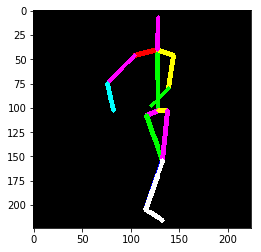

In [107]:
img = np.zeros((224,224,3))
skltn_img = skeleton_image(yt_data['pose_2d'], img)
plt.imshow(skltn_img[:,:,::-1])

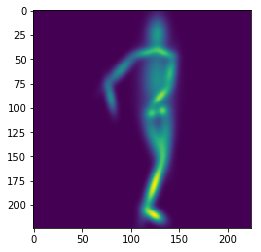

In [109]:
plt.imshow(np.sum(yt_data['aff_maps'],2))

In [103]:
image_name = image[15]
pose_2d = sio.loadmat(os.path.join(mpi_pose_path_2d, 'S6_Seq1_video_8_avi.mat'))['pose_2d'][5780]
pose_2d = np.stack([pose_2d[4,:], pose_2d[1,:], pose_2d[14,:], pose_2d[15,:], pose_2d[16,:], pose_2d[9,:], pose_2d[10,:], 
                  pose_2d[11,:], pose_2d[7,:], pose_2d[23,:], pose_2d[24,:], pose_2d[25,:], pose_2d[27,:], pose_2d[18,:], 
                  pose_2d[19,:], pose_2d[20,:], pose_2d[22,:]], 0)
pose_2d = get_cropped_poses([2048, 2048], pose_2d, 224)

pose_3d = sio.loadmat(os.path.join(mpi_pose_path_3d, 'S6_Seq1_video_8_avi.mat'))['pose_3d'][5780]

scaled_pose = (pose_2d - 0.)*2./224. - 1.
map_pose = np.stack([scaled_pose[:,1], scaled_pose[:,0]],1)

limb_centers_yx, angles, limb_length = get_limb_centers(map_pose)
gauss_map1, gauss_map2 = get_gaussian_maps(np.expand_dims(limb_centers_yx,0), [224,224], 10., mode='rot')
rot_gauss_map1 = get_rot_gaussian_maps(limb_centers_yx, [224,224], width_ratios, length_ratios / limb_length, angles, mode='rot')

sio.savemat('mpi'+'15'+'.mat', {'image_name': image_name, 'pose_2d': pose_2d, 'pose_3d': pose_3d, 
                            'gauss_maps': gauss_map1[0], 'aff_maps': rot_gauss_map1})

(16, 2)
(16, 224, 224)
(16, 224, 224)
(16, 224, 224)


In [96]:
mpi_data = sio.loadmat('mpi11.mat')

In [97]:
mpi_data.keys()

['__globals__',
 'pose_3d',
 'image_name',
 'pose_2d',
 '__header__',
 'aff_maps',
 '__version__',
 'gauss_maps']

In [98]:
mpi_data['image_name']

array([u'/data/vcl/sid/mpi_parsed/parsed_data/center_crops/S1_Seq1_video_8_avi_video_5490_5580_111/crop_params_431_1735_448_1752_37.png'],
      dtype='<U126')

In [ ]:
mpi_

In [90]:
pose1 = np.stack([pose_2d[4,:], pose_2d[1,:], pose_2d[14,:], pose_2d[15,:], pose_2d[16,:], pose_2d[9,:], pose_2d[10,:], 
                  pose_2d[11,:], pose_2d[7,:], pose_2d[23,:], pose_2d[24,:], pose_2d[25,:], pose_2d[27,:], pose_2d[18,:], 
                  pose_2d[19,:], pose_2d[20,:], pose_2d[22,:]], 0)
pose1.shape

(17, 2)

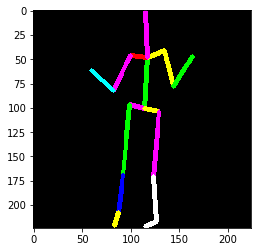

In [100]:
img = np.zeros((224,224,3))
skltn_img = skeleton_image(mpi_data['pose_2d'], img)
plt.imshow(skltn_img[:,:,::-1])

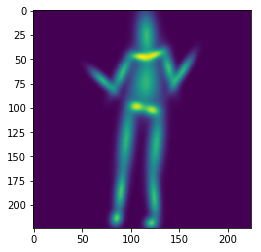

In [101]:
plt.imshow(np.sum(mpi_data['aff_maps'],2))

In [74]:
image_name = image[10]
pose_2d = sio.loadmat(os.path.join(human_pose_path_2d, 'S5_Photo_60457274.mat'))['pose_2d'][1211]
pose_2d = get_cropped_poses([1000, 1000], pose_2d, 224)

pose_3d = sio.loadmat(os.path.join(human_pose_path_3d, 'S5_Photo_60457274.mat'))['pose_3d'][1211]

scaled_pose = (pose_2d - 0.)*2./224. - 1.
map_pose = np.stack([scaled_pose[:,1], scaled_pose[:,0]],1)

limb_centers_yx, angles, limb_length = get_limb_centers(map_pose)
gauss_map1, gauss_map2 = get_gaussian_maps(np.expand_dims(limb_centers_yx,0), [224,224], 10., mode='rot')
rot_gauss_map1 = get_rot_gaussian_maps(limb_centers_yx, [224,224], width_ratios, length_ratios / limb_length, angles, mode='rot')

sio.savemat('human'+'10'+'.mat', {'image_name': image_name, 'pose_2d': pose_2d, 'pose_3d': pose_3d, 
                            'gauss_maps': gauss_map1[0], 'aff_maps': rot_gauss_map1})

(16, 2)
(16, 224, 224)
(16, 224, 224)
(16, 224, 224)


In [68]:
image_name = image[5]
pose_2d = sio.loadmat(os.path.join(mads_pose_path_2d, 'Sports_Tennis_C0.mat'))['pose_2d'][1266]
pose_2d = get_cropped_poses([384, 512], pose_2d, 224)

pose_3d = sio.loadmat(os.path.join(mads_pose_path_3d, 'Sports_Tennis_C0.mat'))['pose_3d'][1266]

scaled_pose = (pose_2d - 0.)*2./224. - 1.
map_pose = np.stack([scaled_pose[:,1], scaled_pose[:,0]],1)

limb_centers_yx, angles, limb_length = get_limb_centers(map_pose)
gauss_map1, gauss_map2 = get_gaussian_maps(np.expand_dims(limb_centers_yx,0), [224,224], 10., mode='rot')
rot_gauss_map1 = get_rot_gaussian_maps(limb_centers_yx, [224,224], width_ratios, length_ratios / limb_length, angles, mode='rot')

sio.savemat('mads'+'5'+'.mat', {'image_name': image_name, 'pose_2d': pose_2d, 'pose_3d': pose_3d, 
                            'gauss_maps': gauss_map1[0], 'aff_maps': rot_gauss_map1})

(16, 2)
(16, 224, 224)
(16, 224, 224)
(16, 224, 224)


In [57]:
mads_data = sio.loadmat('mads1.mat')

In [58]:
mads_data.keys()

['__globals__',
 'pose_3d',
 'image_name',
 'pose_2d',
 '__header__',
 'aff_maps',
 '__version__',
 'gauss_maps']

In [63]:
mads_data['image_name'][0]

u'/data/vcl/sid/mads_parsed/parsed_data/center_crops/HipHop_HipHop1_C0_video_1530_1620_34/crop_params_122_348_90_316_4.png'

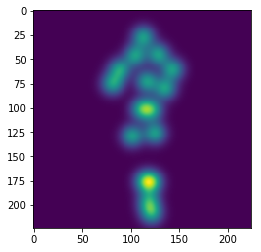

In [59]:
plt.imshow(np.sum(mads_data['gauss_maps'],2))

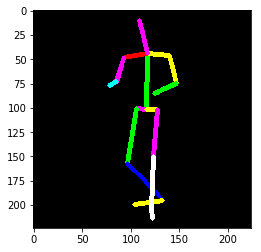

In [61]:
img = np.zeros((224,224,3))
skltn_img = skeleton_image(mads_data['pose_2d'], img)
plt.imshow(skltn_img[:,:,::-1])

In [76]:
human_data = sio.loadmat('human6.mat')

In [77]:
human_data.keys()

['__globals__',
 'pose_3d',
 'image_name',
 'pose_2d',
 '__header__',
 'aff_maps',
 '__version__',
 'gauss_maps']

In [78]:
human_data['image_name'][0]

u'/data/vcl/sid/human36_parsed/parsed_data/center_crops/S1_Directions_60457274_video_405_495_9/crop_params_144_601_203_660_16.png'

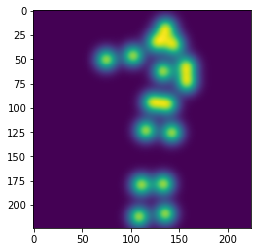

In [79]:
plt.imshow(np.sum(human_data['gauss_maps'],2))

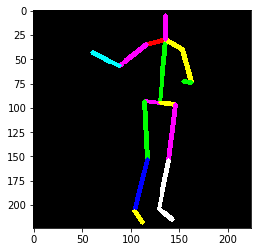

In [80]:
img = np.zeros((224,224,3))
skltn_img = skeleton_image(human_data['pose_2d'], img)
plt.imshow(skltn_img[:,:,::-1])

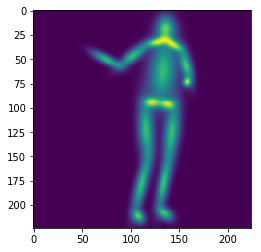

In [83]:
plt.imshow(np.sum(human_data['aff_maps'],2))

In [ ]:

for i in range(6):
    image_name = image[i]
    pose_2d = sio.loadmat(os.path.join(mads_pose_path, image_name.split('/')))
    sio.savemat('mads'+str(i)+'.mat', {'image_name': image_name, 'pose_2d': pose_2d, 'pose_3d': pose_3d, 
                                'maps': maps})
    

In [9]:
'image'+'1'

'image1'

In [8]:
sio.loadmat('/data/vcl/sid/mads_parsed/parsed_data/poses_2d/HipHop_HipHop1_C0.mat')['pose_2d'].shape

(1636, 17, 2)

In [7]:
target_folder1 = 'Jazz_Jazz1_C0_video_0_90_0'
target_folder2 = 'HipHop_HipHop1_C0_video_45_135_1'
target_folder3 = 'HipHop_HipHop1_C0_video_315_405_7'
target_file_name1 = 'crop_params_92_358_90_356_0.png'
target_file_name2 = 'crop_params_101_354_100_353_82.png'
target_file_name3 = 'crop_params_94_366_118_390_89.png'
target_file_name4 = 'crop_params_77_369_84_376_33.png'
target_file_name5 = 'crop_params_128_370_112_354_85'
target_file_name6 = 'crop_params_98_351_68_321_89.png'
pose_path1 = '/data/vcl/sid/mads_parsed/parsed_data/poses_2d/Jazz_Jazz1_C0.mat'
pose_path2 = '/data/vcl/sid/mads_parsed/parsed_data/poses_2d/HipHop_HipHop1_C0.mat'
target_index_actual = int(target_file_name1.split('_')[-1].split('.')[0]) + int(target_folder1.split('_')[-3])
pose_2d = sio.loadmat(pose_path1)['pose_2d'][target_index_actual]
pose_2d = get_cropped_poses([384, 512], pose_2d, 224)

In [8]:
# # pose_path = '/media/babu/disk2/Rakesh_local/vclab@10.24.50.3_mount/mads_parsed/parsed_data/poses_2d/Jazz_Jazz1_C0.mat'
# pose_path = '/data/vcl/sid/mads_parsed/parsed_data/poses_2d/Jazz_Jazz1_C0.mat'
# poses_2d = sio.loadmat(pose_path)['pose_2d']
# pose_2d = poses_2d[0:1]

In [9]:
pose_2d.shape

(17, 2)

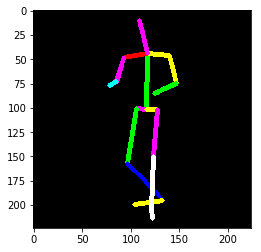

In [15]:
img = np.zeros((224,224,3))
skltn_img = skeleton_image(pose_2d, img)
plt.imshow(skltn_img[:,:,::-1])

In [11]:
pose_2d

array([[110.46334781, 101.68362414],
       [112.21806697,  55.01451461],
       [ 92.65508553,  44.64820087],
       [ 61.78511218,  54.64404502],
       [ 32.13008152,  47.96207392],
       [128.60413905,  43.71128506],
       [162.58240832,  52.40726674],
       [191.81306405,  43.57436418],
       [101.12465509,   9.65255663],
       [ 99.28443289, 101.25977636],
       [ 98.01261609, 165.39407485],
       [ 98.80781271, 207.19639799],
       [ 89.6598979 , 215.30291356],
       [121.69820798, 102.08960583],
       [126.69525883, 164.80763594],
       [130.71883609, 206.16699982],
       [141.24122422, 215.68020234]])

In [12]:
scaled_pose = (pose_2d - 0.)*2./224. - 1.
# scaled_pose = (pose_2d[0] - 0.)*14./512.
map_pose = np.stack([scaled_pose[:,1], scaled_pose[:,0]],1)
map_pose

array([[-0.0921105 , -0.01372011],
       [-0.50879898,  0.00194703],
       [-0.60135535, -0.17272245],
       [-0.51210674, -0.44834721],
       [-0.5717672 , -0.71312427],
       [-0.60972067,  0.14825124],
       [-0.53207798,  0.45162865],
       [-0.61094318,  0.71261664],
       [-0.91381646, -0.09710129],
       [-0.09589485, -0.11353185],
       [ 0.47673281, -0.12488736],
       [ 0.84996784, -0.11778739],
       [ 0.92234744, -0.1994652 ],
       [-0.08848566,  0.08659114],
       [ 0.47149675,  0.13120767],
       [ 0.84077678,  0.16713247],
       [ 0.92571609,  0.26108236]])

In [13]:
scaled_pose.shape

(17, 2)

In [17]:
def get_limb_centers(joints_2d):

    limbs = []
    angles = []
    limb_length = []
    for i in range(1, joints_2d.shape[0]):
        #         ax.text(joints_2d[i, 0], -joints_2d[i, 1], str(i))
        x_pair = [joints_2d[i, 0], joints_2d[limb_parents[i], 0]]
        y_pair = [joints_2d[i, 1], joints_2d[limb_parents[i], 1]]
        limbs.append([(x_pair[0]+x_pair[1])/2., (y_pair[0]+y_pair[1])/2.])
        limb_length.append(np.sqrt((x_pair[0]-x_pair[1])**2 + (y_pair[0]-y_pair[1])**2))
        # calculate slope, m = tan(theta)
        angles.append([(x_pair[0]-x_pair[1]), (y_pair[0]-y_pair[1])]) # because y is represented as x
    angles = np.array(angles)
    print (angles.shape)
    angles = np.arctan2(angles[:,0],angles[:,1]+1e-7)
    limbs = np.array(limbs)
    limb_length = np.array(limb_length)
    return limbs, angles, limb_length

In [18]:
limb_centers_yx, angles, limb_length = get_limb_centers(map_pose)

(16, 2)


In [19]:
limb_centers_yx.shape

(16, 2)

In [20]:
limb_centers_yx

array([[-0.3453571 ,  0.04577924],
       [-0.58577138, -0.06053087],
       [-0.45592176, -0.20374456],
       [-0.32573694, -0.27063324],
       [-0.59523695,  0.15015489],
       [-0.45605966,  0.28257741],
       [-0.28151863,  0.21429117],
       [-0.75532884,  0.01338424],
       [-0.09095241, -0.00374664],
       [ 0.15607589, -0.08900265],
       [ 0.57512765,  0.03235482],
       [ 0.76193386,  0.06337486],
       [-0.08452565,  0.09065828],
       [ 0.12975548,  0.11975083],
       [ 0.58247937,  0.09128234],
       [ 0.87107767,  0.08794157]])

In [21]:
angles.shape

(16,)

In [22]:
limb_length

array([0.5153104 , 0.22057991, 0.23544582, 0.07407931, 0.20409046,
       0.26989491, 0.21589573, 0.3126076 , 0.09402282, 0.50637529,
       0.46474628, 0.25989816, 0.0952241 , 0.42378596, 0.48368314,
       0.09488704])

In [23]:
gauss_map1, gauss_map2 = get_gaussian_maps(np.expand_dims(limb_centers_yx,0), [224,224], 10., mode='rot')

In [24]:
gauss_map1.shape

(1, 224, 224, 16)

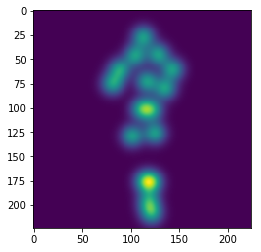

In [25]:
plt.imshow(np.sum(gauss_map1[0,:,:,:],2))

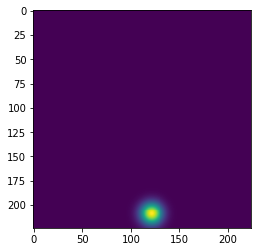

In [26]:
plt.imshow(gauss_map1[0,:,:,15])

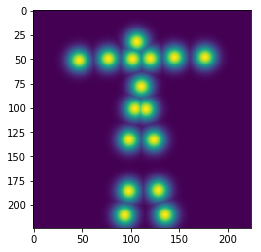

In [28]:
plt.imshow(np.amax(gauss_map1[0,:,:,:],2))

In [27]:
# decreasing the value of ratio increases the length of the gaussian
length_ratios1 = np.array([2., 3., 2., 2.5, 3., 2., 2.5, 3.,
                          1.25, 2.5, 2.5, 1.75, 1.25, 2.5, 2.5, 1.75])
length_ratios = np.ones_like(length_ratios1)*2.
# decreasing the value of ratio increases the width of the gaussian
width_ratios = np.array([8., 25., 20., 25., 25., 20., 25., 12.,
                          20., 15., 20., 20., 20., 15., 20., 20.])

In [28]:
rot_gauss_map1 = get_rot_gaussian_maps(limb_centers_yx, [224,224], width_ratios, length_ratios / limb_length, angles, mode='rot')

(16, 224, 224)
(16, 224, 224)
(16, 224, 224)


In [33]:
type(rot_gauss_map1[0,0,0])

numpy.float64

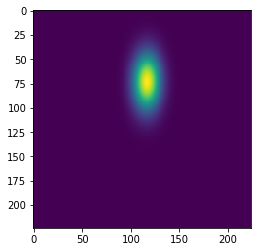

In [29]:
plt.imshow(rot_gauss_map1[:,:,0])

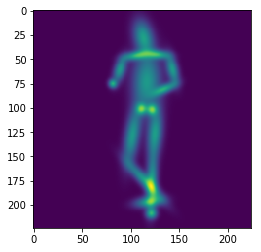

In [30]:
plt.imshow(np.sum(rot_gauss_map1[:,:,:],2))

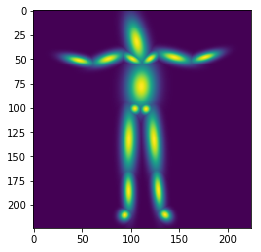

In [33]:
plt.imshow(np.amax(rot_gauss_map1[:,:,:],2))

In [ ]:
# H3.6
data/vcl/sid/human36_parsed/parsed_data/center_crops/S1_Discussion 1_60457274_video_1845_1935_41/crop_params_151_627_188_664_19.png
data/vcl/sid/human36_parsed/parsed_data/center_crops/S1_Discussion_55011271_video_360_450_8/crop_params_236_600_325_689_78.png    
data/vcl/sid/human36_parsed/parsed_data/center_crops/S1_Eating_60457274_video_585_675_13/crop_params_212_634_341_763_29.png
data/vcl/sid/human36_parsed/parsed_data/center_crops/S1_Discussion_60457274_video_1575_1665_35/crop_params_143_623_189_669_46.png
data/vcl/sid/human36_parsed/parsed_data/center_crops/S5_Greeting%201_55011271_video_45_135_1/crop_params_249_581_418_750_8.png
data/vcl/sid/human36_parsed/parsed_data/center_crops/S5_Photo%202_60457274_video_1485_1575_33/crop_params_382_605_284_507_6.png
data/vcl/sid/human36_parsed/parsed_data/center_crops/S5_WalkDog_55011271_video_450_540_10/crop_params_250_600_271_621_37.png
data/vcl/sid/human36_parsed/parsed_data/center_crops/S6_Directions%201_60457274_video_0_90_0/crop_params_141_572_295_726_65.png
data/vcl/sid/human36_parsed/parsed_data/center_crops/S7_Discussion_54138969_video_1395_1485_31/crop_params_286_669_394_777_52.png
data/vcl/sid/human36_parsed/parsed_data/center_crops/S8_Posing_55011271_video_540_630_12/crop_params_223_576_403_756_77.png
data/vcl/sid/human36_parsed/parsed_data/center_crops/S8_Photo%201_60457274_video_225_315_5/crop_params_201_607_336_742_85.png

index = int(image_name.split('_')[-1].split('.')[0]) + int(folder_name.split('_')[-3])
sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_2d/'+folder_name.split('_video')[0]+'.mat')['pose_2d'][index]

In [ ]:
# MADS
data/vcl/sid/mads_parsed/parsed_data/center_crops/Jazz_Jazz2_C1_video_1170_1260_26/crop_params_162_331_158_327_7.png
data/vcl/sid/mads_parsed/parsed_data/center_crops/Jazz_Jazz2_C0_video_1260_1350_28/crop_params_97_360_104_367_32.png
data/vcl/sid/mads_parsed/parsed_data/center_crops/HipHop_HipHop6_C1_video_1440_1530_32/crop_params_129_329_168_368_65.png
data/vcl/sid/mads_parsed/parsed_data/center_crops/HipHop_HipHop3_C0_video_0_90_0/crop_params_75_375_95_395_37.png
data/vcl/sid/mads_parsed/parsed_data/center_crops/HipHop_HipHop3_C0_video_0_90_0/crop_params_75_378_114_417_0.png
data/vcl/sid/mads_parsed/parsed_data/center_crops/HipHop_HipHop1_Left_video_0_90_0/crop_params_122_362_123_363_76.png
data/vcl/sid/mads_parsed/parsed_data/center_crops/Sports_Tennis_C0_video_495_585_11/crop_params_87_353_148_414_1.png
data/vcl/sid/mads_parsed/parsed_data/center_crops/Sports_Rugby_C1_video_180_270_4/crop_params_124_340_157_373_49.png
data/vcl/sid/mads_parsed/parsed_data/center_crops/Sports_Football_Left_video_945_1035_21/crop_params_89_336_205_452_0.png
data/vcl/sid/mads_parsed/parsed_data/center_crops/Sports_Football_C1_video_675_765_15/crop_params_128_321_105_298_30.png
data/vcl/sid/mads_parsed/parsed_data/center_crops/Sports_Basketball_C2_video_1080_1170_24/crop_params_117_334_61_278_37.png

# Pose
index = int(image_name.split('_')[-1].split('.')[0]) + int(folder_name.split('_')[-3])
sio.loadmat('/data/vcl/sid/mads_parsed/parsed_data/poses_2d/'+folder_name.split('_video')[0]+'.mat')['pose_2d'][index]

In [ ]:
# MPI

In [ ]:
# YT
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_110/crop_params_38_419_254_635_1906.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_110/crop_params_41_431_209_599_3890.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_110/crop_params_45_436_187_578_3167.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_104/crop_params_36_444_277_685_2523.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_104/crop_params_49_439_265_655_982.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_103/crop_params_23_444_248_669_1408.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_103/crop_params_25_444_305_724_273.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_102/crop_params_43_406_282_645_126.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_24/crop_params_0_443_189_632_1679.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_10/crop_params_0_416_133_549_2522.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_10/crop_params_0_420_112_532_2532.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_3/crop_params_44_443_262_661_1103.jpg
data/vcl/sid/in_the_w_parsed/center_crops_full/dance_3/crop_params_46_444_214_612_1543.jpg

# Pose
index = int(image_name.split('_')[-1].split('.')[0])
sio.loadmat('/data/vcl/sid/in_the_w_parsed/poses_2d/'+video+'.mat')['pose_2d'][index]